In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, norm
import os.path

import IPython

test_idx=6558
sel_points = [1173,4644,1891,4936,1735,3562]

# 'damping' means no damping or weight decay (oops), same as LBFGS
# 'special' means regular CNN-type settings with damping/wd
# 'relaxed' means less aggressive learning rate

#mode = 'special' # doesn't converge enough for hessian computation - can still "compute" with damping
    # we compute predicted stuff using damping of 1e-2
mode = 'relaxed' # doesn't converge enough for hessian computation - can still "compute" with damping
    # we compute predicted stuff using damping of 1e-3
num_iters = 550
incomplete_losses_removed = []
imcomplete_warm_losses = []

sns.set(color_codes=True)
sns.set_style('white')

def ceil_divide(numer,denom):
    return (numer-1)//denom+1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
seed = 0
"""f = np.load('../../output/{}_seed{}_warm_pred_infl_remove_{}.npz'.format(mode,seed,sel_points))
predicted_loss_diffs = f['pred_infl']
warm_loss_diffs = f['warm_infl']"""
if mode == "relaxed":
    predicted_loss_diffs = [ 0.05975626,  0.03937472, -0.00190148, -0.01983952, -0.03516891, -0.0138074 ]
elif mode == "special":
    predicted_loss_diffs = [ 0.02219712,  0.00887477, -0.00432513, -0.00146471,  0.00838769, -0.00059714]

f = np.load('../../output/{}_mnist_small_all_cnn_c_hidden2_seed{}_iter-{}000_seed{}_losses.npz'.format(mode,seed,num_iters,seed))
losses = f['losses']
losses_fine = f['losses_fine']

losses_removed = []
losses_removed_fine = []
diffs = []
diffs_fine = []
warm_losses = []
for point in sel_points:
    if point not in incomplete_losses_removed:
        f = np.load('../../output/{}_seed{}_remove{}_only_losses.npz'.format(mode,seed,point))
        losses_removed.append(f['losses_removed'])
        losses_removed_fine.append(f['losses_removed_fine'])
        diffs.append(np.subtract(losses_removed[-1],losses))
        diffs_fine.append(np.subtract(losses_removed_fine[-1],losses_fine))
    if point not in imcomplete_warm_losses:
        f = np.load('../../output/{}_mnist_small_all_cnn_c_hidden2_seed{}_iter-{}000_remove{}_retrain_losses.npz'.format(mode,seed,num_iters,point))
        warm_losses.append(f['retrain_losses'])
diffs = np.array(diffs)
diffs_fine = np.array(diffs_fine)
warm_losses = np.array(warm_losses)
warm_loss_diffs = np.subtract(warm_losses[:,-1],losses[-1])

[ 0.03562927  0.0131228  -0.02062321 -0.03687096 -0.05115676 -0.02272534]
[0.05975626, 0.03937472, -0.00190148, -0.01983952, -0.03516891, -0.0138074]
0.9927329686673493


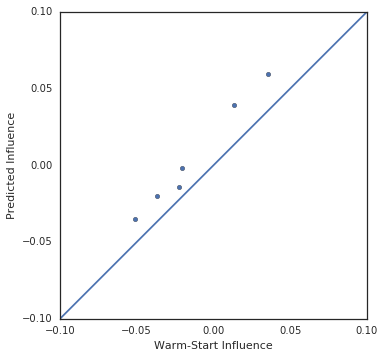

In [18]:
print(warm_loss_diffs)
plt.scatter(warm_loss_diffs, predicted_loss_diffs)#[sel_points])
#plt.scatter(diffs[:,-1], predicted_loss_diffs,color='r')#[sel_points],color='r')
plt.axes().set_aspect('equal')
plt.xlim(-0.1,0.1)
plt.ylim(-0.1,0.1)
plt.plot([-0.1,0.1],[-0.1,0.1])
plt.xlabel('Warm-Start Influence')
plt.ylabel('Predicted Influence')
print(predicted_loss_diffs)#[sel_points])
print(pearsonr(warm_loss_diffs,predicted_loss_diffs)[0])

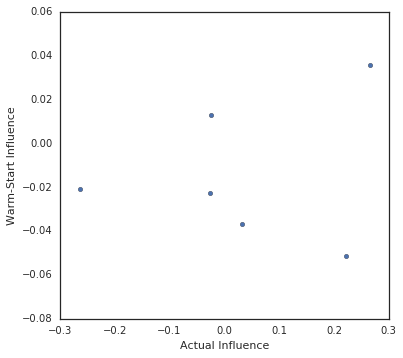

In [19]:
plt.scatter(diffs[:,-1],warm_loss_diffs)
plt.xlabel('Actual Influence')
plt.ylabel('Warm-Start Influence')
#plt.plot([-0.1,0.1],[-0.1,0.1])
if mode == 'relaxed':
    plt.axes().set_aspect(4)
elif mode == 'special':
    plt.axes().set_aspect(25)

In [20]:
def plot_tracked_losses(seed,point,first):
    assert point in sel_points
    idx = sel_points.index(point)

    sns.set_style('white')
    fontsize=16
    fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(8, 8))
    plt.subplots_adjust(wspace=0.4)
    plt.suptitle('Seed {} Remove {}'.format(seed, point))
    #plt.suptitle('Seed {} Remove {}: {}'.format(seed, point, predicted_loss_diffs[point]))
    
    axs[0][0].plot(range(first,num_iters),losses[first:],color='b')
    if point not in incomplete_losses_removed:
        axs[0][0].plot(range(first,num_iters),losses_removed[idx][first:],color='r')
    if point not in imcomplete_warm_losses:
        axs[0][0].plot(range(num_iters,num_iters*3),warm_losses[idx],color='g')
    axs[0][0].set_xlabel('Thousands of steps')
    axs[0][0].set_ylabel('Loss on test pt')

    if point not in incomplete_losses_removed:
        axs[0][1].scatter(range(first,num_iters),diffs[idx][first:],alpha=0.5,color='r')
    if point not in imcomplete_warm_losses:
        axs[0][1].scatter(range(num_iters,num_iters*3),np.subtract(warm_losses[idx],losses[-1]),alpha=0.2,color='g')
    axs[0][1].set_xlabel('Thousands of steps')
    axs[0][1].set_ylabel('Diff in loss')
    axs[0][1].hlines(0,-1,1351,color='k',alpha=0.5,zorder=1)
    #axs[0][1].plot(range(300), np.poly1d(np.polyfit(range(300), diffs, 1))(range(300)),color='r')

    axs[1][0].plot(range(first,100),losses_fine[first:])
    if point not in incomplete_losses_removed:
        axs[1][0].plot(range(first,100),losses_removed_fine[idx][first:],color='r')
    axs[1][0].set_xlabel('Steps')
    axs[1][0].set_ylabel('Loss on test pt')

    if point not in incomplete_losses_removed:
        axs[1][1].scatter(range(first,100),diffs_fine[idx][first:],alpha=0.5,color='r')
    axs[1][1].set_xlabel('Steps')
    axs[1][1].set_ylabel('Diff in loss')
    axs[1][1].hlines(0,first-1,101,color='k',alpha=0.5,zorder=1)
    #axs[1][1].plot(range(100), np.poly1d(np.polyfit(range(100), diffs_fine, 1))(range(100)),color='r')
    
    if point not in incomplete_losses_removed:
        print("Orig {}, removed {}".format(losses[449],losses_removed[idx][449]))
        print("Actual: {}".format(losses_removed[idx][449]-losses[449]))
    #print("Pred: {}".format(predicted_loss_diffs[point]))

Orig 1.88279914856, removed 2.14716076851
Actual: 0.264361619949
Orig 1.88279914856, removed 1.8561719656
Actual: -0.0266271829605
Orig 1.88279914856, removed 1.61544954777
Actual: -0.267349600792
Orig 1.88279914856, removed 1.91634273529
Actual: 0.033543586731
Orig 1.88279914856, removed 2.10314202309
Actual: 0.220342874527
Orig 1.88279914856, removed 1.85428273678
Actual: -0.0285164117813


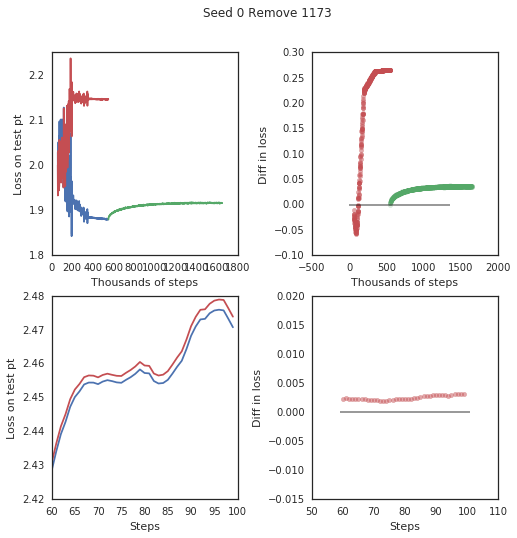

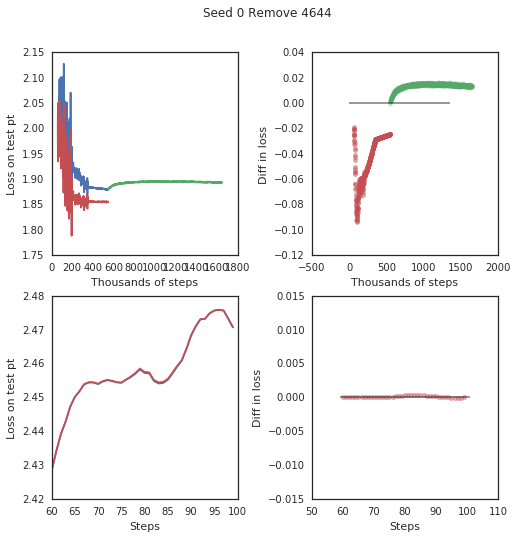

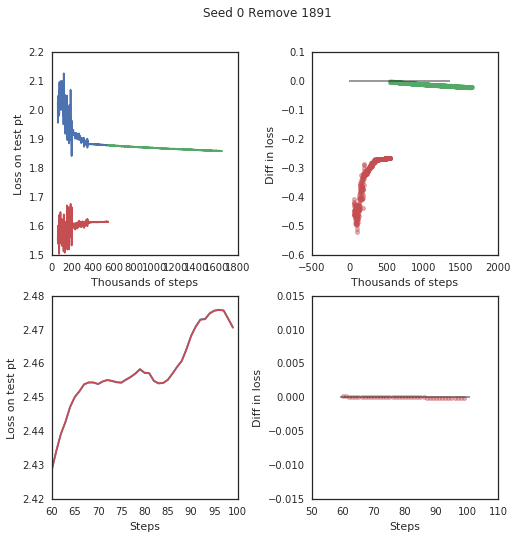

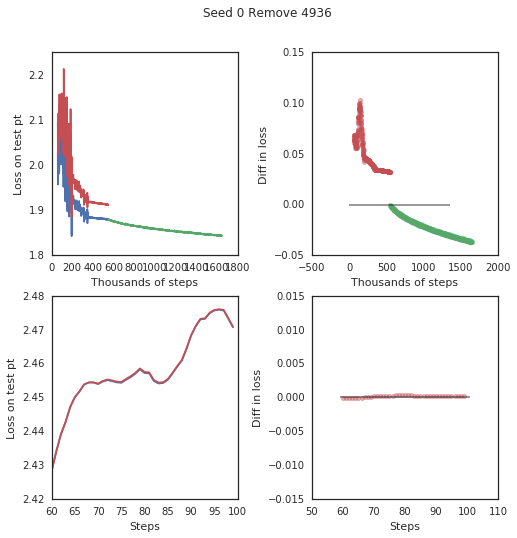

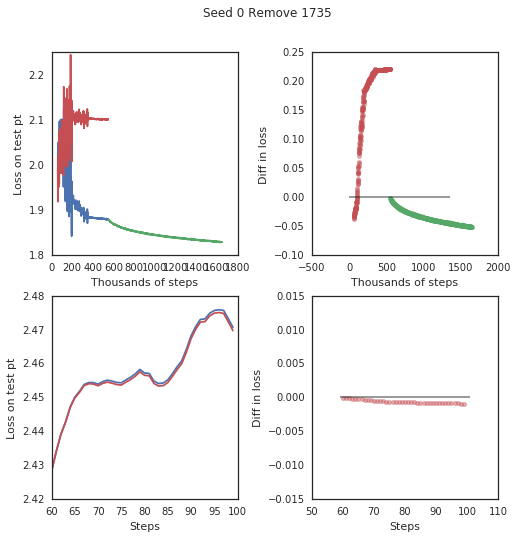

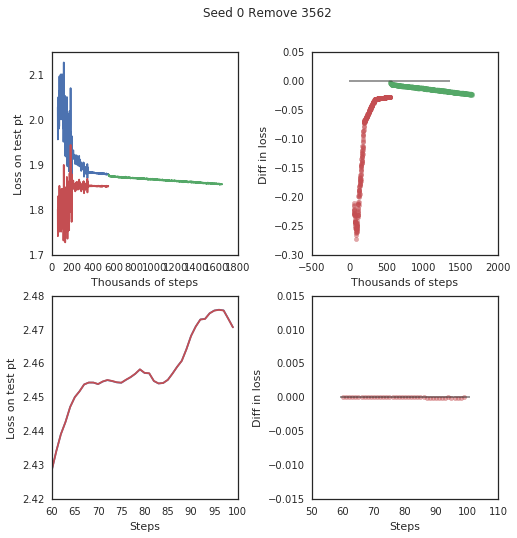

In [21]:
for point in sel_points:
    plot_tracked_losses(0,point,60)

Orig 1.88279914856, removed 2.14716076851
Actual: 0.264361619949
Orig 1.88279914856, removed 1.8561719656
Actual: -0.0266271829605
Orig 1.88279914856, removed 1.61544954777
Actual: -0.267349600792
Orig 1.88279914856, removed 1.91634273529
Actual: 0.033543586731
Orig 1.88279914856, removed 2.10314202309
Actual: 0.220342874527
Orig 1.88279914856, removed 1.85428273678
Actual: -0.0285164117813


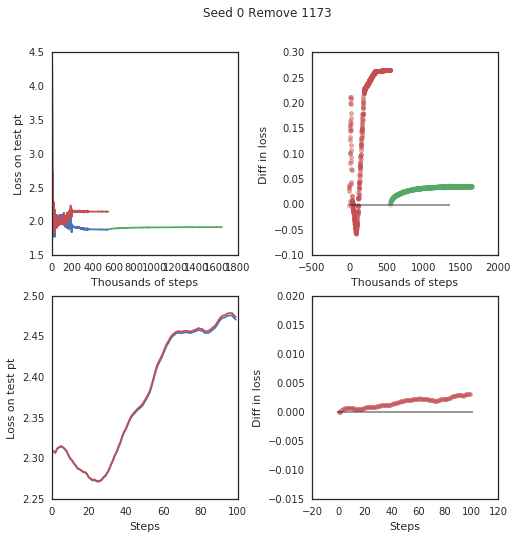

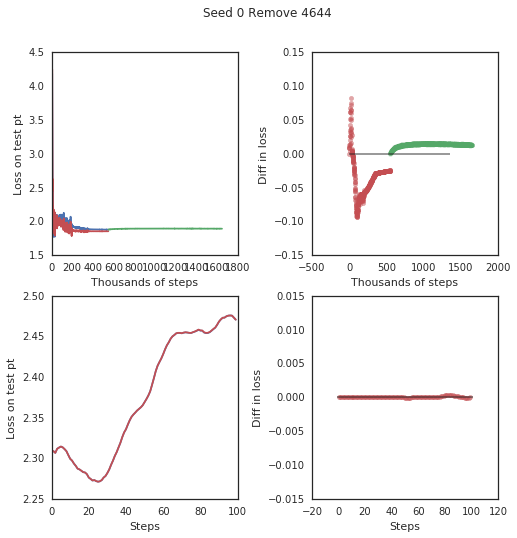

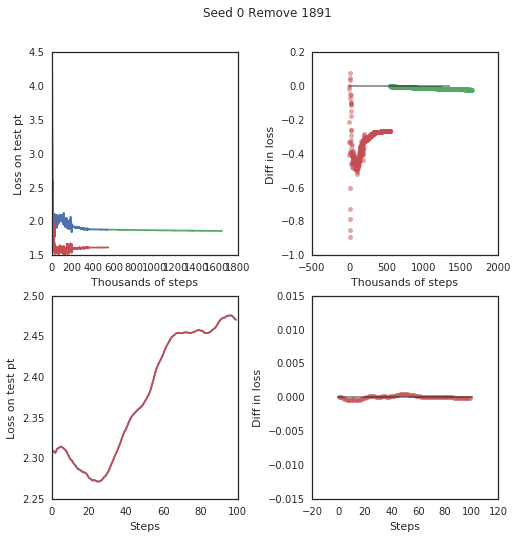

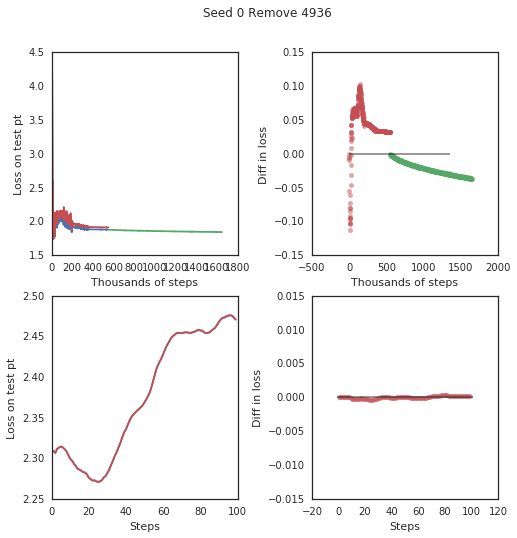

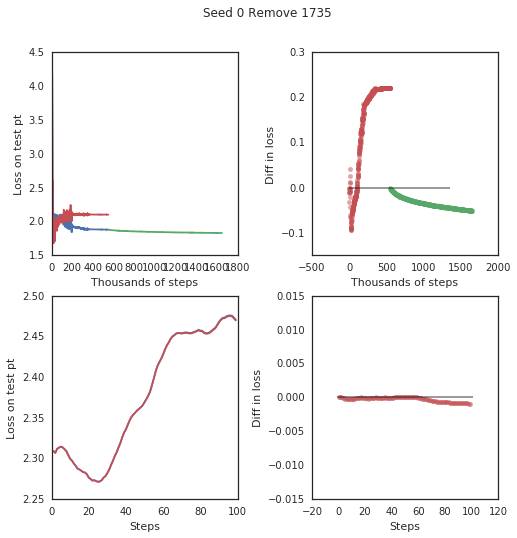

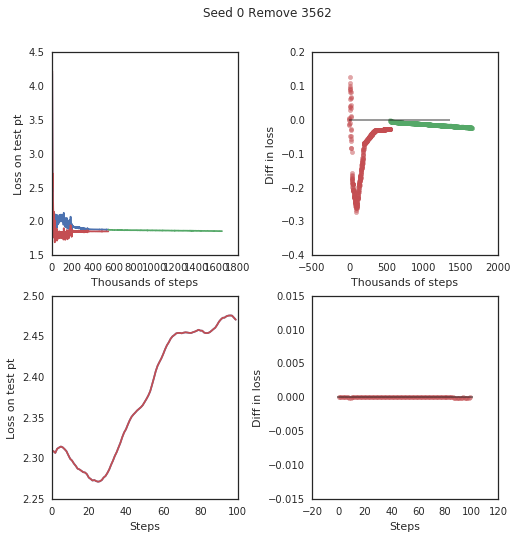

In [22]:
for point in sel_points:
    plot_tracked_losses(0,point,0)

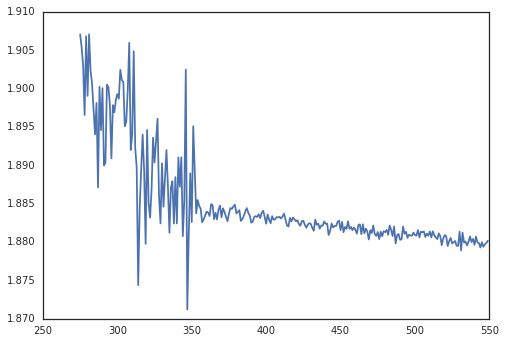

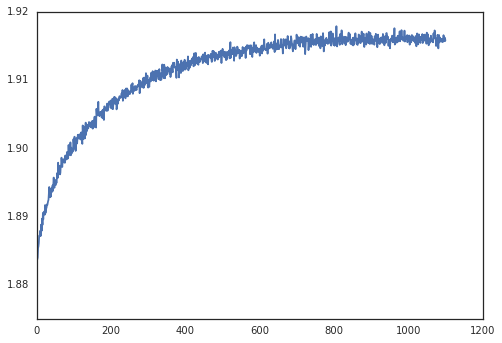

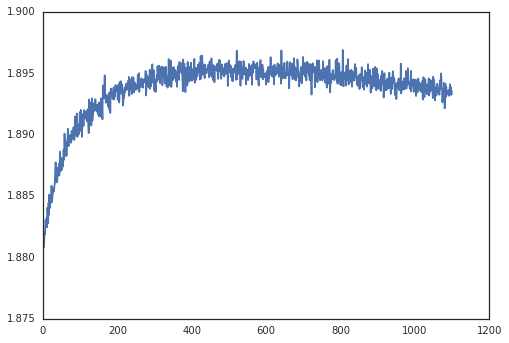

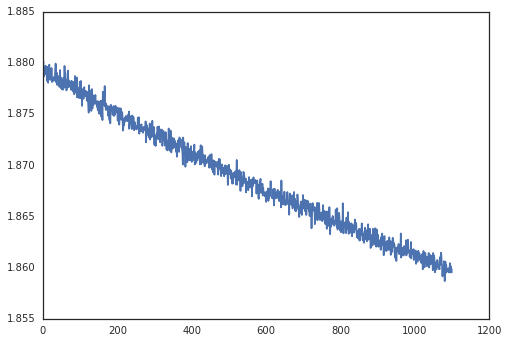

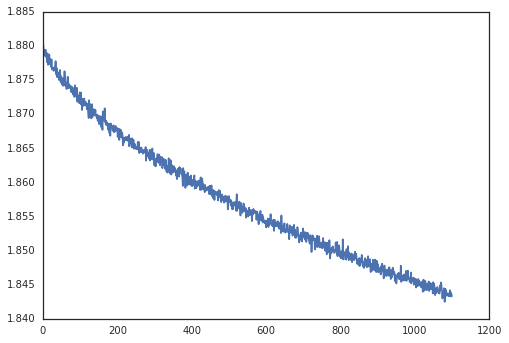

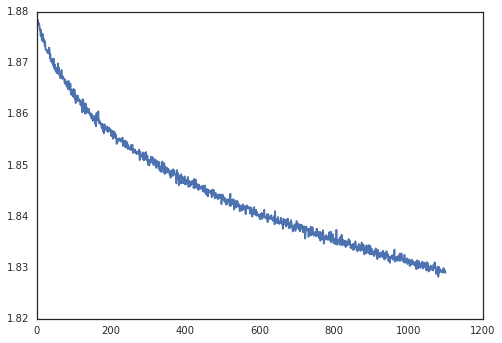

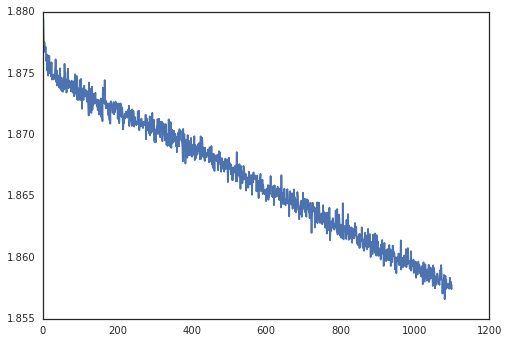

In [23]:
plt.plot(range(num_iters//2,num_iters),losses[num_iters//2:num_iters])
plt.show()

for arr in warm_losses:
    plt.plot(range(len(arr)),arr)
    plt.show()